# Term Structure

_UNDER CONSTRUCTION_

- yield curve, duration, DV01, bootstrap

- term structure shifts

- splines



In [2]:
from typing import List, Dict, Any
import re
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from finds.readers import Alfred
from finds.busday import BusDay
from finds.misc import Show
from finds.finance import Interest
from secret import credentials, paths
VERBOSE = 0
show = Show(ndigits=4, latex=None)
# %matplotlib qt
imgdir = paths['images'] / 'ts'

In [3]:
alf = Alfred(api_key=credentials['fred']['api_key'])

## Term Structure of Interest Rates

In [4]:
## list of monthly Constant Maturity Treasury, excluding inflation-indexed
c = alf.get_category(115)  # Fed H.15 Selected Interest Rates
print(c['id'], c['name'])
t = Series({s['id']: s['title'] for s in c['series']
            if (s['frequency']=='Monthly'
                and 'Inflation' not in s['title']
                and 'DISCONT' not in s['title'])}).rename('title')
show(t.to_frame(), formatters=[lambda x: x.split(',')[0]],
     caption="Constant Maturity Treasuries in FRED")

https://api.stlouisfed.org/fred/category?category_id=115&api_key=eb428f329807459fa7bee89be4ebbc3b&file_type=json
https://api.stlouisfed.org/fred/category/children?category_id=115&api_key=eb428f329807459fa7bee89be4ebbc3b&file_type=json
https://api.stlouisfed.org/fred/category/series?category_id=115&api_key=eb428f329807459fa7bee89be4ebbc3b&file_type=json&offset=0
https://api.stlouisfed.org/fred/category/series?category_id=115&api_key=eb428f329807459fa7bee89be4ebbc3b&file_type=json&offset=1000
115 Treasury Constant Maturity


,title
Constant Maturity Treasuries in FRED,
GS1,Market Yield on U.S. Treasury Securities at 1-...
GS10,Market Yield on U.S. Treasury Securities at 10...
GS1M,Market Yield on U.S. Treasury Securities at 1-...
GS2,Market Yield on U.S. Treasury Securities at 2-...
GS20,Market Yield on U.S. Treasury Securities at 20...
GS3,Market Yield on U.S. Treasury Securities at 3-...
GS30,Market Yield on U.S. Treasury Securities at 30...
GS3M,Market Yield on U.S. Treasury Securities at 3-...
GS5,Market Yield on U.S. Treasury Securities at 5-...


In [5]:
## retrieve CMT yields, and infer maturity from label
data = [alf(s, freq='M') for s in t.index]
data = pd.concat([alf(s, freq='M') for s in t.index], axis=1, join='inner')
data.columns = [int(re.sub('\D', '', col)) * (1 if col.endswith('M') else 12)
                for col in data.columns]  # infer maturity in months from label
data = data.sort_index(axis=1)            # sort columns by ascending maturity
show(data)

,1,3,6,12,24,36,60,84,120,240,360
date,,,,,,,,,,,
20010731,3.67,3.59,3.56,3.62,4.04,4.31,4.76,5.06,5.24,5.75,5.61
20010831,3.53,3.44,3.39,3.47,3.76,4.04,4.57,4.84,4.97,5.58,5.48
20010930,2.68,2.69,2.71,2.82,3.12,3.45,4.12,4.51,4.73,5.53,5.48
20011031,2.27,2.20,2.17,2.33,2.73,3.14,3.91,4.31,4.57,5.34,5.32
20011130,1.99,1.91,1.92,2.18,2.78,3.22,3.97,4.42,4.65,5.33,5.12
...,...,...,...,...,...,...,...,...,...,...,...
20230331,4.49,4.86,4.99,4.68,4.30,4.09,3.82,3.77,3.66,3.94,3.77
20230430,4.17,5.07,4.99,4.68,4.02,3.76,3.54,3.50,3.46,3.80,3.68
20230531,5.49,5.31,5.27,4.91,4.13,3.82,3.59,3.58,3.57,3.96,3.86


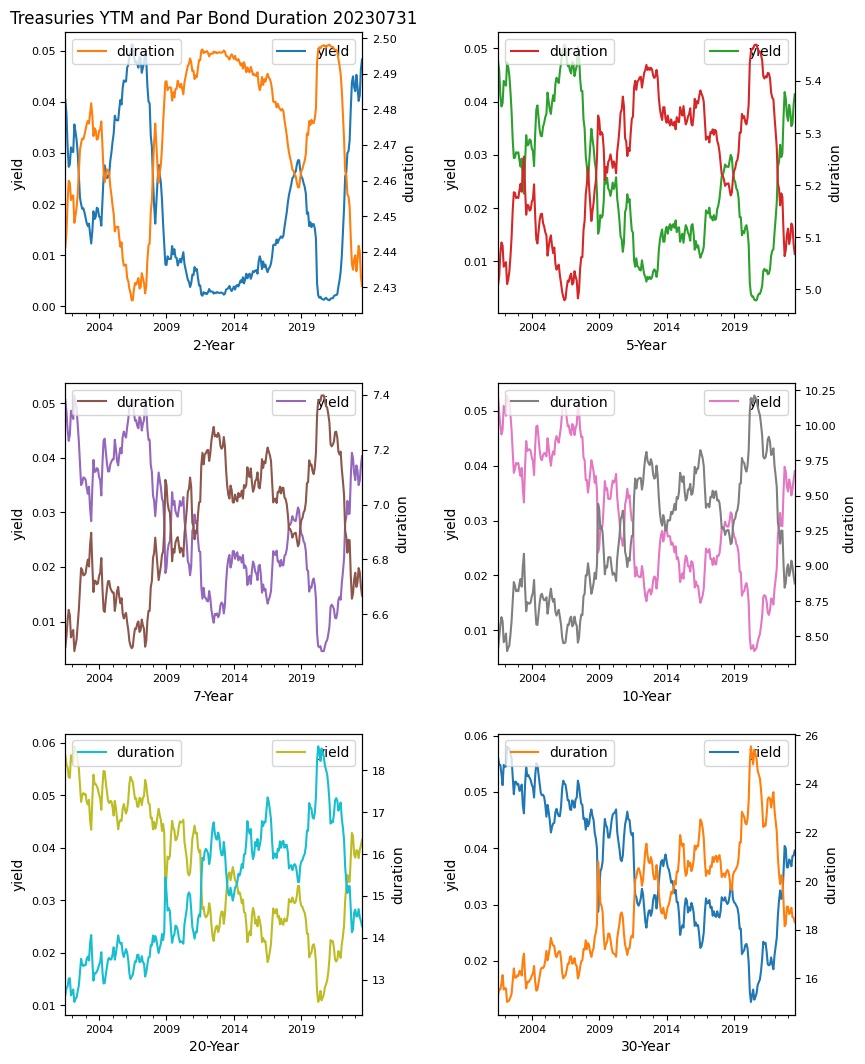

In [6]:
## Plot history of yields and durations
yields = pd.concat([data[yr * 12].rename(yr) / 100
                    for yr in [2, 5, 7, 10, 20, 30]], axis=1)
yields.index = pd.to_datetime(yields.index, format='%Y%m%d')
durations = pd.concat([yields[yr].apply(Interest.par_duration, n=yr, m=2)
                       for yr in yields], axis=1)
fig, axes = plt.subplots(3, 2, clear=True, num=1, figsize=(9, 11))
for i in range(6):
    ax = axes[i // 2, i % 2]
    title = (i==0)*f"Treasuries YTM and Par Bond Duration {data.index[-1]}"
    yields.iloc[:, i].rename('yield')\
                     .plot(ax=ax, c=f"C{i*2}", fontsize=8, legend=True,
                           ylabel='yield', title=title)
    bx = ax.twinx()
    durations.iloc[:, i]\
             .rename('duration')\
             .plot(ax=bx, c=f"C{i*2+1}", fontsize=8, ylabel='duration',
                   legend=True)
    ax.set_xlabel(f"{yields.columns[i]}-Year")
plt.tight_layout(pad=2)
plt.savefig(imgdir / 'term.jpg')

## Splines

- Interpolate yield curve

In [7]:
## https://home.treasury.gov/policy-issues/financing-the-government/
##   interest-rate-statistics/treasury-yield-curve-methodology
curve_date = 20211231 #data.index[-1] # for latest date available 20021231 #
from scipy.interpolate import CubicSpline
yields = data.loc[curve_date].values
maturities = data.columns.to_list()
yield_curve = CubicSpline(x=maturities, y=yields, bc_type='clamped')

In [8]:
## Bootstrap nominal annual rates from interpolated ytm semi-annually
ytm = [yield_curve(t) / 100 for t in range(6, 361, 6)]  
m = 2
nominal = np.array([])   # to store annualized rates from bootstrap
for y in ytm:
    nominal = np.append(nominal,
                        Interest.bootstrap_rates(y, nominal=nominal, m=m))
spot_rates = (((1 + np.array(nominal/2))**2) - 1) * 100  # annualize effective

In [9]:
## Sanity-check spot rate results 
for n in range(1, 1 + len(ytm)):  # discounted cash flows all close to par=1?
    assert abs(Interest.discounted_cash_flow(flows=ytm[n-1] / m,
                                             spot=nominal[:n] / m)
               + Interest.present_value(1, n=n, spot=nominal[n-1] / m)-1) < 0.001

In [10]:
f = np.array(Interest.forward_rates(spot=nominal / m))  # as single-period rate
for n in range(1, 1+len(ytm)):  # compounded forwards all close to nominal
    assert abs(np.prod(1 + f[:n])
               - (1 + nominal[n-1] / m)**n) < 0.001
forwards = (((1 + np.array(f))**2) - 1) * 100  # annual effective forward

In [11]:
# Retrieve reconstructed yield curve history
## https://sites.google.com/view/jingcynthiawu/yield-data
def fetch_liuwu(file_id='1_u9cRxmOSiwp_tFvlaORuhS-zwl935s0'):
    src = "https://drive.google.com/uc?export=download&id={}".format(file_id)
    x = pd.ExcelFile(src)
    df = x.parse()
    dates = np.where(df.iloc[:, 0].astype(str).str[0].str.isdigit())[0]
    return DataFrame(np.exp(df.iloc[dates,1:361].astype(float).values/100) - 1,
                     index=BusDay.to_monthend(df.iloc[dates, 0].values),
                     columns=np.arange(1, 361))
df = fetch_liuwu()
reconstructed_rates = df.loc[curve_date, :] * 100             # as of curve_date
f = np.array(Interest.forward_rates(spot=reconstructed_rates / 1200)) 
reconstructed_forward = (((1 + np.array(f))**12) - 1) * 100   # annualize

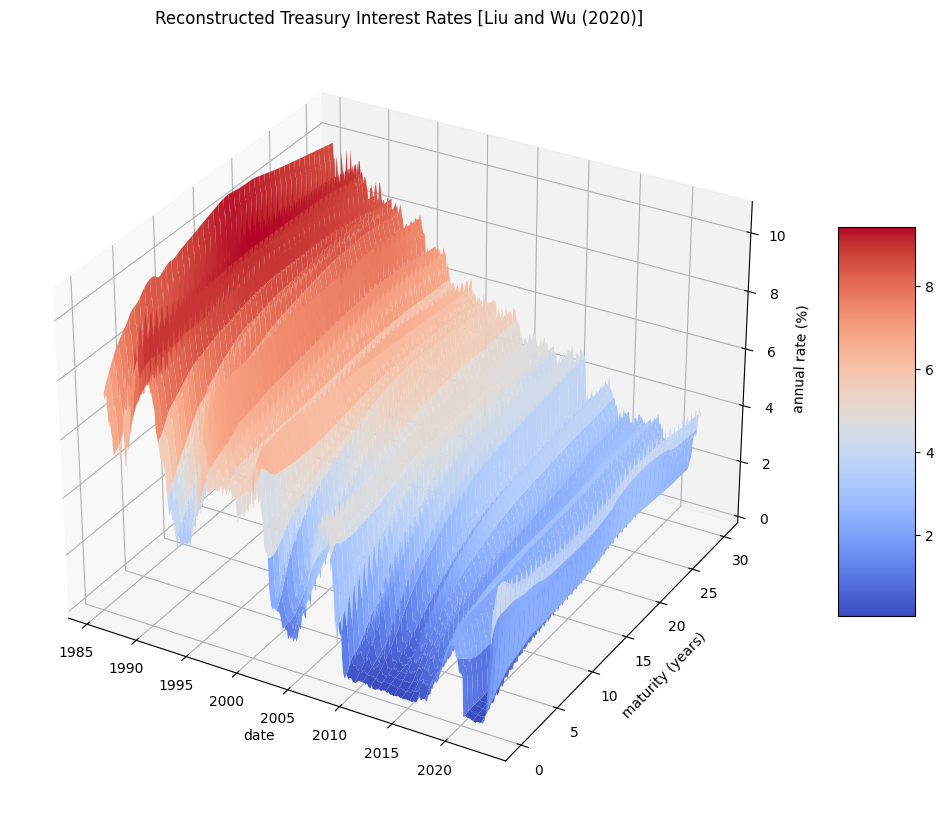

In [12]:
## Plot historical reconstructed rates as 3D surface
from mpl_toolkits.mplot3d import Axes3D
r = df.dropna()
X, Y = np.meshgrid((r.index//10000) + ((((r.index//100)%100)-1)/12),
                   r.columns.astype(float)/12)
Z = r.T.to_numpy()*100
fig = plt.figure(num=1, clear=True, figsize=(10,8))
ax = plt.axes(projection='3d')
f = ax.plot_surface(X, Y, Z, cmap='coolwarm', linewidth=0, antialiased=True)
ax.set_title('Reconstructed Treasury Interest Rates [Liu and Wu (2020)]')
ax.set_xlabel('date')
ax.set_ylabel('maturity (years)')
ax.set_zlabel('annual rate (%)')
fig.colorbar(f, shrink=0.5, aspect=5)
plt.tight_layout(pad=0)
plt.savefig(imgdir / 'reconstructed.jpg')

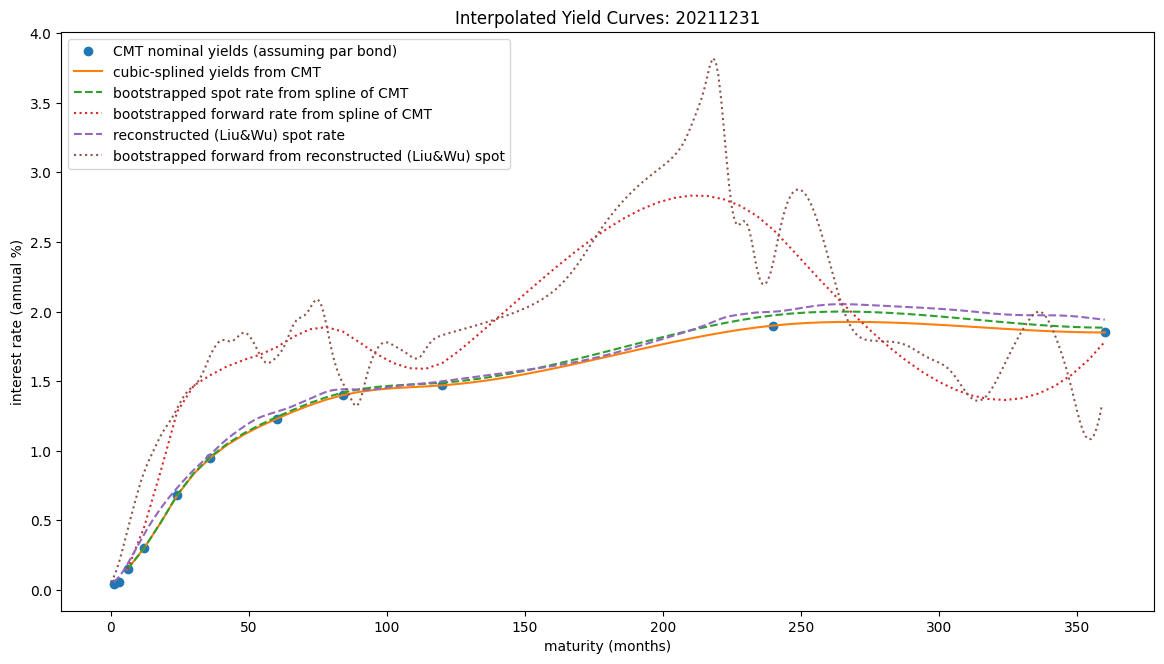

In [13]:
# Plot yield curves as of recent date
semi_annual = np.arange(6, 361, 6)     # enumerate semi-annual months
fig, ax = plt.subplots(num=1, clear=True, figsize=(12,7))
ax.plot(maturities,
        yields, 'o',
        label='CMT nominal yields (assuming par bond)')
ax.plot(semi_annual,
        yield_curve(semi_annual),
        label="cubic-splined yields from CMT")
ax.plot(semi_annual,
        spot_rates, '--',
        label="bootstrapped spot rate from spline of CMT")
ax.plot(semi_annual,
        forwards, ':',
        label="bootstrapped forward rate from spline of CMT")
ax.plot(reconstructed_rates,  '--',
        label="reconstructed (Liu&Wu) spot rate")
ax.plot(reconstructed_forward,  ':',
        label="bootstrapped forward from reconstructed (Liu&Wu) spot")
ax.set_title(f"Interpolated Yield Curves: {curve_date}")
ax.set_xlabel('maturity (months)')
ax.set_ylabel('interest rate (annual %)')
ax.legend()
plt.tight_layout(pad=2)
plt.savefig(imgdir / 'curve.jpg')